In [4]:
import QuantLib as ql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import ctypes
from pylab import plt
import utils
plt.style.use('seaborn')
%matplotlib inline

In [5]:
class TimeStructure:
    def __init__(self, times):
        self._times = np.array(times)
    @property
    def num_times(self):
        return self._times.size
    @property
    def tenors(self):
        return np.diff(self._times)
    def time(self, timeindex):    
        return self._times[timeindex]
    def tenor(self, timeindex):   
        return self._times[timeindex + 1] - self._times[timeindex]
class MonteCarloConfig:
    def __init__(self, num_paths, num_factors):
        self._num_paths = num_paths
        self._num_factors = num_factors
    @property
    def num_paths(self):
        return self._num_paths
    @property
    def num_factors(self):
        return self._num_factors

In [6]:
#volatility
from abc import ABC, abstractmethod
import numpy as np

class Volatility(ABC):
    @abstractmethod
    def volatility(self):
        pass  
    @abstractmethod
    def calibrate(self):
        pass
class PiecewiseConstVolatility(Volatility):
        def __init__(self, timestruct, capletvolas):
            self._timestruct = timestruct
            self._capletvolas = capletvolas
            num_rates = timestruct.num_times - 1
            self._volas = np.zeros((num_rates, timestruct.num_times))
        @property
        def volatility(self):
            return self._volas 
        def calibrate(self):
            T_1 = self._timestruct.time(1)
            bs_volas = []
            for i, capletvola in enumerate(self._capletvolas, 2):
                bs_vola = capletvola**2 * self._timestruct.time(i-1)
                for j, vola in enumerate(bs_volas, 2):
                    bs_vola -= vola**2 * self._timestruct.tenor(j-1)
                bs_volas.append(np.sqrt(bs_vola/T_1))
            self._volas[1:, 1] = bs_volas
            for i in range(2, self._timestruct.num_times):
                self._volas[i:, i] = bs_volas[:-i+1]

In [7]:
#correlation
from abc import ABC, abstractmethod
import numpy as np
class Correlation(ABC):    
    @abstractmethod
    def compute(self):
        pass
    @abstractmethod
    def correlation(self):
        pass    
    @abstractmethod
    def corr_sqrt(self):  
        pass
class ReducedFactorCorrelation(Correlation):
    
    def __init__(self, correlation, num_factors):
        self._correlation = correlation
        self._num_factors = num_factors

        corr_dim = correlation.shape[0]
        self._corr_sqrt = np.zeros((corr_dim, num_factors))
        self._corr_reduced = np.zeros(correlation.shape)
    @property
    def correlation(self):
        return self._corr_reduced
    @property
    def corr_sqrt(self):
        return self._corr_sqrt
    def compute(self):
        eigvals, eigvecs = np.linalg.eig(self._correlation)
        sorted_indices = eigvals.argsort()[::-1][:self._num_factors]
        eigvals = eigvals[sorted_indices]
        eigvecs = eigvecs.T[sorted_indices]
        sqrt = np.column_stack([np.sqrt(l)*v for l, v in zip(eigvals, eigvecs)])
        covariance = sqrt @ sqrt.T
        normalize = lambda i, j: sqrt[i, j]/np.sqrt(covariance[i, i])
        self._corr_sqrt = np.fromfunction(normalize, self._corr_sqrt.shape, dtype=int)
        self._corr_reduced = self._corr_sqrt @ self._corr_sqrt.T

In [8]:
#interestratemodel
from abc import ABC, abstractmethod
import numpy as np

class InterestRateModel(ABC):
    @abstractmethod
    def rate(self, rateindex, timeindex):
        pass
    @abstractmethod
    def numeraire(self, rateindex, timeindex):
        pass
    @abstractmethod
    def simulate(self):
        pass
class LiborMarketModel(InterestRateModel):
    def __init__(self, mc_config, timestruct, volatility, correlation, forwardcurve):
        self._timestruct = timestruct
        self._volatility = volatility
        self._correlation = correlation
        self._forwardcurve = forwardcurve
        self._mc_config = mc_config
        shape = (timestruct.num_times - 1, timestruct.num_times, mc_config.num_paths)
        self._rates = np.zeros(shape)
        self._numeraire = np.zeros(shape)
    def rate(self, rateindex, timeindex):
        return self._rates[rateindex, timeindex]
    def numeraire(self, rateindex, timeindex):
        return self._numeraire[rateindex, timeindex]
    def simulate(self):
        mean = np.zeros(self._mc_config.num_factors)
        cov = np.identity(self._mc_config.num_factors)
        increments = np.random.multivariate_normal(mean, cov, (self._timestruct.num_times, self._mc_config.num_paths))
        num_rates = self._timestruct.num_times - 1
        rho = self._correlation.correlation
        vols = self._volatility.volatility
        tau = self._timestruct.tenors
        sqrt_tau = np.sqrt(tau)
        for k in range(self._mc_config.num_paths):
            L = self._rates[:, :, k]
            P = self._numeraire[:, :, k]
            L[:, 0] = self._forwardcurve
            P[:, 0] = np.cumprod(1/(1 + tau*L[:, 0]))
            for j in range(1, self._timestruct.num_times):
                drift = np.zeros(num_rates)
                for m in range(j+1, num_rates):
                    drift[m] = ((rho[m, j]*tau[m-1]*L[m, j-1]*vols[m, j])/(1 + tau[m-1]*L[m, j-1]))
                for i in range(j, num_rates):
                    dW = self._correlation.corr_sqrt[i, :] @ increments[j, k]
                    L[i, j] = L[i, j-1] * np.exp((-vols[i, j] * np.sum(drift[i+1:]) 
                              - 0.5 * vols[i, j]**2) * tau[j] + vols[i, j] * sqrt_tau[j] * dW)
                    P[i, j] = (1 if i==j else P[i-1, j])/(1 + tau[j]*L[i, j])
                             

In [10]:
data = pd.read_excel('finalworkdataois.xlsx',index_col='date')
data.index = pd.to_datetime(data.index)

data1 = pd.read_excel('finalworkdatas.xlsx',index_col='date')
data1.index = pd.to_datetime(data.index)
#data = data['2005-1']

In [11]:
data.loc[data.index[0]].index

Float64Index([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], dtype='float64')

In [12]:
#boost OIS Curve

t = np.array([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])

calendar = ql.TARGET()
todaysDate = ql.Date(6,1,2001);
ql.Settings.instance().evaluationDate = todaysDate
settlementDate = ql.Date(8,1,2001)

fixedLegFrequency = ql.Annual
fixedLegAdjustment = ql.Unadjusted
fixedLegDayCounter = ql.Actual360()
floatingLegFrequency = ql.Semiannual
floatingLegAdjustment = ql.ModifiedFollowing
floatingLegTenor = ql.Period(1,ql.Days)
fixedLegTenor = ql.Period(1,ql.Years)
OIS_index = ql.Eonia()

zeros_1=[]
for i in range(data.shape[0]):
    swap_helpers= []
    zeros_ois =[]
    df = []
    tasa_6m = data.iloc[i][0.5]
    depo_helper = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(tasa_6m/100)),
                                        ql.Period(6,ql.Months),0,calendar,fixedLegAdjustment,False,ql.Actual360())]
    for x in data.columns[1:]:
        rate = data.iloc[i][x]
        
        swap_helpers += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)),
                               ql.Period(int(x*12),ql.Months), calendar,
                               fixedLegFrequency, fixedLegAdjustment,
                               fixedLegDayCounter, OIS_index)]
    
    helper = depo_helper + swap_helpers
    curva = ql.PiecewiseCubicZero(todaysDate, helper, ql.Actual360())
    zeros_ois += [curva.zeroRate(x,ql.Simple).rate()*100 for x in data.columns]
    zeros_1.append(zeros_ois)
    print(zeros_ois)

[1.8709515325624704, 2.2758735399292407, 2.76969021475056, 3.2691512211677543, 3.683091780888344, 4.102646221388828, 4.426947055754926, 4.7420978334579535, 5.017967249682057, 5.275903543223537]
[1.8909504925000764, 2.2977566808778604, 2.7955335905718455, 3.3000365536467013, 3.692870895228628, 4.088092490921643, 4.405350201155007, 4.713946082537623, 4.984331330640766, 5.236748988555746]
[1.862951945505431, 2.225430895784286, 2.704918375325871, 3.1914840365380726, 3.5786612510722198, 3.9688596066983792, 4.285038923956762, 4.593674314007323, 4.863702246335025, 5.116728084573072]
[1.8599520999050156, 2.225334718207095, 2.7049243780189247, 3.191475303989044, 3.5786654122267962, 3.96885355633377, 4.285043475765819, 4.593669761889579, 4.863706824425544, 5.116726109440113]
[1.8709515325624704, 2.230631063939148, 2.702705229413782, 3.1807940780695154, 3.5773859069767155, 3.978723665215885, 4.296782239495478, 4.606856989696862, 4.878558131754031, 5.133308115674482]
[1.8749513254304961, 2.2433154

In [14]:
data = pd.read_excel('finalworkdatas.xlsx',index_col='date')
data.index = pd.to_datetime(data.index)
#data = data['2008-1']

In [15]:
discountCurve = zeros_1

In [16]:
zeros_1=np.asarray(zeros_1)
num1 = zeros_1.shape[0]-1

In [17]:
Spot_Curve_OIS_Zero = zeros_1[num1,:]/100

In [18]:
Spot_Curve_OIS_Zero

array([0.01956947, 0.01769612, 0.01672359, 0.01569269, 0.01539805,
       0.01508257, 0.01506552, 0.01501684, 0.01514029, 0.01524292])

In [19]:
data.loc[data.index[0]].index

Float64Index([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], dtype='float64')

In [20]:
#boost swap libor Curve

t = np.array([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])

calendar = ql.TARGET()
todaysDate = ql.Date(6,1,2001);
ql.Settings.instance().evaluationDate = todaysDate
settlementDate = ql.Date(8,1,2001)

fixedLegFrequency = ql.Semiannual
fixedLegAdjustment = ql.Unadjusted
fixedLegDayCounter = ql.Thirty360()
floatingLegFrequency = ql.Semiannual
floatingLegAdjustment = ql.ModifiedFollowing
floatingLegTenor = ql.Period(6,ql.Months)
fixedLegTenor = ql.Period(1,ql.Years)
        

libor6M_index = ql.USDLibor(ql.Period(6, ql.Months))
zeros_2=[]
for i in range(data.shape[0]):
    swap_helpers= []
    zeros = []
    df = []
    tasa_6m = data.iloc[i][0.5]
    depo_helper = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(tasa_6m/100)),
                                        ql.Period(6,ql.Months),0,calendar,fixedLegAdjustment,False,ql.Actual360())]
    for x in data.columns[1:]:
        rate = data.iloc[i][x]
        
        swap_helpers += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)),
                               ql.Period(int(x*12),ql.Months), calendar,
                               fixedLegFrequency, fixedLegAdjustment,
                               fixedLegDayCounter, libor6M_index, ql.QuoteHandle(), ql.Period(1,ql.Days))]

                                           
    helper = depo_helper +swap_helpers
    curva = ql.PiecewiseCubicZero(todaysDate, helper, ql.Actual360())
    zeros += [curva.zeroRate(x,ql.Simple).rate()*100 for x in data.columns]
    zeros_2.append(zeros)
    print(zeros)

[2.0274431002434756, 2.432128396633071, 2.9465006572505725, 3.451224765468952, 3.8770562289475134, 4.285428073993406, 4.612122752861092, 4.949479778254534, 5.229007945016893, 5.503767882260959]
[2.0549415489464096, 2.4480412653755, 2.9449957194440364, 3.4308606435840105, 3.8551405257137366, 4.262969227743444, 4.589004189162641, 4.92608079878682, 5.198759207310398, 5.465692409292822]
[2.059941264658516, 2.3770124418677208, 2.8614397145955817, 3.3372877654937017, 3.768761716747378, 4.186444565792949, 4.5051868659740215, 4.832314219732758, 5.107451905727355, 5.378262563585521]
[2.0318228545562977, 2.375629108894306, 2.8613762967912404, 3.337230599856722, 3.7682051188011196, 4.1854072976965195, 4.502415352618166, 4.827793152037057, 5.0984130239214664, 5.364199175681641]
[2.0299429600756813, 2.3803424480769664, 2.8640564163466093, 3.337643109733912, 3.760598478971735, 4.167994936364439, 4.49464677295618, 4.832150648308808, 5.108101471423292, 5.378828122566595]
[2.0399423976859676, 2.3756084

In [21]:
zeros_2=np.asarray(zeros_2)/100
zeros_2
d = zeros_2[:,0]

In [22]:
zeros_2=np.asarray(zeros_2)
num = zeros_2.shape[0]-1

In [23]:
Spot_Curve_libor = zeros_2[num,:]
Spot_Curve_libor

array([0.02208812, 0.02010824, 0.01913415, 0.01799569, 0.01774948,
       0.01739438, 0.01737266, 0.01734168, 0.01747753, 0.01759993])

In [24]:
forward=[]
for i in range(0,10):
    d=((1+(zeros_2[:,i])*(1+i)*0.5)/(1+(zeros_2[:,i-1])*0.5*i)-1)/0.5
    forward.append(d)

In [25]:
forward=np.transpose(forward)

In [26]:
corr_forward= np.corrcoef((forward.T))
correlation_matrix = corr_forward
pd.DataFrame(corr_forward)

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.951229,0.873758,0.769648,0.660233,0.543382,0.452895,0.343139,0.274262,0.183191
1,0.951229,1.000000,0.969013,0.907731,0.826273,0.733365,0.653562,0.555787,0.486574,0.398529
2,0.873758,0.969013,1.000000,0.982357,0.932061,0.866805,0.796381,0.713945,0.645653,0.564365
3,0.769648,0.907731,0.982357,1.000000,0.976581,0.936054,0.877224,0.810792,0.746599,0.674338
4,0.660233,0.826273,0.932061,0.976581,1.000000,0.988545,0.957279,0.913505,0.863055,0.805843
5,0.543382,0.733365,0.866805,0.936054,0.988545,1.000000,0.985756,0.959745,0.918487,0.873493
6,0.452895,0.653562,0.796381,0.877224,0.957279,0.985756,1.000000,0.991970,0.970658,0.940642
7,0.343139,0.555787,0.713945,0.810792,0.913505,0.959745,0.991970,1.000000,0.990540,0.973027
8,0.274262,0.486574,0.645653,0.746599,0.863055,0.918487,0.970658,0.990540,1.000000,0.994536
9,0.183191,0.398529,0.564365,0.674338,0.805843,0.873493,0.940642,0.973027,0.994536,1.000000


In [27]:
forwardcurve=forward[len(forward)-1]
forwardcurve = forwardcurve.T

In [28]:
tenors = np.array([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])

In [29]:
termstruct = TimeStructure(tenors)

In [30]:
caplet = pd.read_excel(r'capletvolas.xlsx',)
caplet

,date,capletvolas
0,1.0,0.60330
1,1.5,0.62820
2,2.0,0.65310
3,2.5,0.66745
4,3.0,0.68180
5,3.5,0.68605
6,4.0,0.69030
7,4.5,0.68245
8,5.0,0.67460


In [31]:
capletvolas = np.array(caplet['capletvolas'])
capletvolas

array([0.6033 , 0.6282 , 0.6531 , 0.66745, 0.6818 , 0.68605, 0.6903 ,
       0.68245, 0.6746 ])

In [32]:
Number_Simulation = 2000

In [33]:
config = MonteCarloConfig(Number_Simulation, 4)

In [34]:
volatility = PiecewiseConstVolatility(termstruct, capletvolas)

In [35]:
correlation = ReducedFactorCorrelation(correlation_matrix, config.num_factors)

In [36]:
libor_marketmodel = LiborMarketModel(config, termstruct, volatility, correlation,forwardcurve)

In [37]:
volatility.calibrate()

In [38]:
correlation.compute()
pd.DataFrame(correlation._corr_reduced)

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.953169,0.873761,0.769914,0.660532,0.543941,0.453382,0.343696,0.274099,0.182901
1,0.953169,1.000000,0.971650,0.912183,0.826799,0.733414,0.653519,0.555554,0.487944,0.400350
2,0.873761,0.971650,1.000000,0.982614,0.932736,0.867925,0.797339,0.715047,0.645570,0.564144
3,0.769914,0.912183,0.982614,1.000000,0.978375,0.938549,0.879439,0.813187,0.746849,0.674200
4,0.660532,0.826799,0.932736,0.978375,1.000000,0.988614,0.957530,0.913948,0.863374,0.806398
5,0.543941,0.733414,0.867925,0.938549,0.988614,1.000000,0.986074,0.960257,0.919172,0.874505
6,0.453382,0.653519,0.797339,0.879439,0.957530,0.986074,1.000000,0.992000,0.971426,0.941876
7,0.343696,0.555554,0.715047,0.813187,0.913948,0.960257,0.992000,1.000000,0.991586,0.974615
8,0.274099,0.487944,0.645570,0.746849,0.863374,0.919172,0.971426,0.991586,1.000000,0.994595
9,0.182901,0.400350,0.564144,0.674200,0.806398,0.874505,0.941876,0.974615,0.994595,1.000000


In [39]:
libor_marketmodel.simulate()

In [40]:
df_lmm = np.flip(1/(1+libor_marketmodel._rates*0.5))

In [41]:
df_lmm.shape

(10, 11, 2000)

In [42]:
pd.DataFrame(df_lmm[0,:,:])

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.990336,0.998869,0.992673,0.999450,0.999321,0.998851,0.986155,0.996192,0.999002,0.997551,...,0.999421,0.976786,0.998985,0.998645,0.979658,0.997546,0.996964,0.994898,0.940117,0.998342
2,0.980384,0.998462,0.988110,0.999114,0.998378,0.998572,0.984996,0.996845,0.999350,0.996370,...,0.999048,0.974687,0.998704,0.998549,0.990065,0.997754,0.997328,0.995272,0.941276,0.997900
3,0.975725,0.998725,0.982392,0.998262,0.998444,0.998518,0.987493,0.997566,0.999608,0.993229,...,0.998886,0.939753,0.997216,0.998493,0.987431,0.998776,0.998237,0.996423,0.973254,0.997760
4,0.965604,0.998965,0.987819,0.997535,0.998456,0.997803,0.991950,0.996514,0.999245,0.995237,...,0.996998,0.966397,0.996239,0.999418,0.991450,0.997135,0.998421,0.994842,0.974465,0.997896
5,0.969533,0.999513,0.993643,0.995233,0.995787,0.998762,0.989357,0.992205,0.998836,0.994533,...,0.994550,0.972009,0.998603,0.999504,0.990088,0.997371,0.995804,0.993583,0.973570,0.998072
6,0.987283,0.998825,0.994382,0.993117,0.990146,0.997272,0.988330,0.991231,0.998332,0.995466,...,0.994214,0.973990,0.998120,0.998329,0.981318,0.997712,0.994669,0.981734,0.976565,0.996508
7,0.990718,0.995867,0.994567,0.992316,0.989811,0.997897,0.987734,0.987731,0.998057,0.996890,...,0.992106,0.977786,0.996202,0.998082,0.985163,0.996059,0.984660,0.977834,0.975540,0.992163
8,0.995474,0.993662,0.994422,0.993383,0.994159,0.986670,0.990321,0.987654,0.994090,0.994508,...,0.993250,0.984868,0.995121,0.995409,0.987274,0.994890,0.986269,0.993300,0.981058,0.989536
9,0.995894,0.994717,0.992323,0.991577,0.986810,0.988777,0.989556,0.989684,0.994475,0.992199,...,0.983808,0.979671,0.992203,0.990481,0.991869,0.990128,0.992527,0.993059,0.994529,0.991770


In [43]:
fw_simulation = []
df_fra = np.zeros(shape=[Number_Simulation,11])
df = np.zeros_like(df_fra)
tasa = np.zeros_like(df_fra)
yf = np.arange(0,5.5,0.5)
for i in range(libor_marketmodel._rates.shape[2]):
    df_fra[i,:] = np.flip(1/(1+libor_marketmodel._rates[-1,:,i]*0.5))
    df[i,:] = np.cumprod(df_fra[i,:])
    
tasa = pd.DataFrame(tasa)
df = pd.DataFrame(df)
tasa.drop(columns=[0], inplace=True)

In [44]:
libor_marketmodel._rates.shape

(10, 11, 2000)

In [45]:
zero_bonds= df
zero_bonds = np.array(zero_bonds)
v = np.zeros(shape=(Number_Simulation,11,11))
for j in range(11):
    v[:,j,:] = zero_bonds
zero_bond = v

In [46]:
df_lmm.shape

(10, 11, 2000)

In [47]:
df_lmm2 = np.zeros(shape=(Number_Simulation,10,11))

In [48]:
zero_bond.shape

(2000, 11, 11)

In [49]:
# Setting evaluation date for NPV for swap´s
today = ql.Date(7,7,2014)
ql.Settings.instance().setEvaluationDate(today)
calendar = ql.TARGET()

In [50]:
# Setup Marketdata
rate = ql.SimpleQuote(0.0175)
rate_handle = ql.QuoteHandle(rate)
dc = ql.Actual365Fixed()
yts = ql.FlatForward(today, rate_handle, dc)
yts.enableExtrapolation()
hyts = ql.RelinkableYieldTermStructureHandle(yts)
t0_curve = ql.YieldTermStructureHandle(yts)
Libor6m = ql.Euribor6M(hyts)


In [51]:
# Setup a dummy portfolio with two Swaps
def makeSwap(start, maturity, nominal, fixedRate, index, typ=ql.VanillaSwap.Payer):
    """
    creates a plain vanilla swap with fixedLegTenor 5Y
  
        
    """
    end = ql.TARGET().advance(start, maturity)
    fixedLegTenor = ql.Period(6,ql.Months)
    fixedLegBDC = ql.ModifiedFollowing
    fixedLegDC = ql.Thirty360(ql.Thirty360.BondBasis)
    spread = 0.0
    fixedSchedule = ql.Schedule(start,
                                end, 
                                fixedLegTenor, 
                                index.fixingCalendar(), 
                                fixedLegBDC,
                                fixedLegBDC, 
                                ql.DateGeneration.Backward,
                                False)
    floatSchedule = ql.Schedule(start,
                                end,
                                index.tenor(),
                                index.fixingCalendar(),
                                index.businessDayConvention(),
                                index.businessDayConvention(),
                                ql.DateGeneration.Backward,
                                False)
    swap = ql.VanillaSwap(typ, 
                          nominal,
                          fixedSchedule,
                          fixedRate,
                          fixedLegDC,
                          floatSchedule,
                          index,
                          spread,
                          index.dayCounter())
    return swap, [index.fixingDate(x) for x in floatSchedule][:-1]

portfolio = [makeSwap(today + ql.Period("2d"),
                      ql.Period("5Y"),
                      1,
                      0.0175,
                      Libor6m, ql.VanillaSwap.Receiver),

            ]

In [52]:
# Define evaluation grid
date_grid = [date + ql.Period(i*6,ql.Months) for i in range(2,2)]
for deal in portfolio:
    date_grid += deal[1]

date_grid = np.unique(np.sort(date_grid))
time_grid = np.vectorize(lambda x: ql.ActualActual().yearFraction(today, x))(date_grid)
dt = time_grid[1:] - time_grid[:-1]
time_grid2 = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,4.8,5,6]
date_grid
discount_factors = np.vectorize(t0_curve.discount)(time_grid)

In [53]:
#%%timeit
# Setup pricing engine and calculate the npv
engine = ql.DiscountingSwapEngine(hyts)
for deal, fixingDates in portfolio:
    deal.setPricingEngine(engine)
    deal.NPV()

In [54]:
N = Number_Simulation 

In [55]:
#%%timeit
#Swap pricing under each scenario
npv_cube = np.zeros((Number_Simulation,len(date_grid), len(portfolio)))
for p in range(0,Number_Simulation):
    for t in range(0, len(date_grid)):
        date = date_grid[t]
        ql.Settings.instance().setEvaluationDate(date)
        ycDates = [date, date + ql.Period(6, ql.Months)] 
        ycDates += [date + ql.Period(i*6,ql.Months) for i in range(2,11)] 
        yc = ql.DiscountCurve(ycDates, 
                              zero_bond[p, t, :], 
                              ql.Actual365Fixed(),ql.TARGET())
        yc.enableExtrapolation()
        hyts.linkTo(yc)
        if Libor6m.isValidFixingDate(date):
            fixing = Libor6m.fixing(date)
            Libor6m.addFixing(date, fixing)
        for i in range(len(portfolio)):
            npv_cube[p, t, i] = portfolio[i][0].NPV()
    ql.IndexManager.instance().clearHistories()
ql.Settings.instance().setEvaluationDate(today)
hyts.linkTo(yts)

In [56]:
# Calculate the discounted npvs
discounted_cube = np.zeros(npv_cube.shape)
for i in range(npv_cube.shape[2]):
    discounted_cube[:,:,i] = npv_cube[:,:,i] * discount_factors

In [57]:
npv_cube.shape

(2000, 10, 1)

In [58]:
npv_cube[1,9,:]

array([-0.10650371])

In [59]:
# Calculate the discounted npvs
discounted_cube = np.zeros(npv_cube.shape)
for i in range(npv_cube.shape[2]):
    discounted_cube[:,:,i] = npv_cube[:,:,i] 

In [60]:
# Calculate the portfolio npv by netting all NPV
portfolio_npv = np.sum(npv_cube,axis=2)
discounted_npv = np.sum(discounted_cube, axis=2)

In [61]:
portfolio_npv.shape

(2000, 10)

In [62]:
portfolio_npv2 = np.zeros(shape=(Number_Simulation,13))
for i in range (0, Number_Simulation):
    for j in range (1, 11):
        portfolio_npv2[i, j] = portfolio_npv[i, j-1]

In [63]:
portfolio_npv2.shape

(2000, 13)

In [64]:
discounted_npv2 = np.zeros(shape=(Number_Simulation,13))
for i in range (0, Number_Simulation):
    for j in range (1, 11):
        discounted_npv2[i, j] = discounted_npv[i, j-1]

In [65]:
portfolio_npv = portfolio_npv2
discounted_npv = discounted_npv2


Text(0.5, 1.0, 'Simulated npv paths')

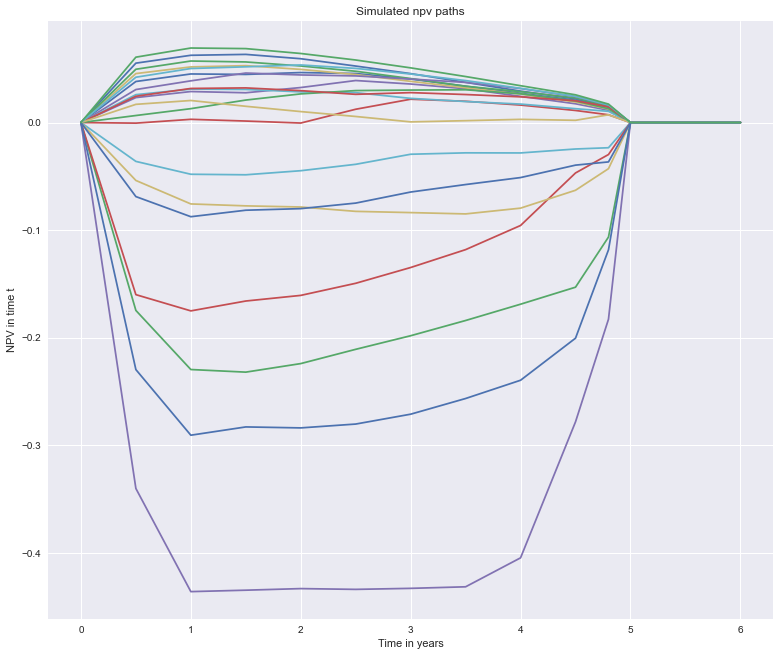

In [66]:
# Plot the 20 NPV first paths
n_0 = 0
n = 20
f, (ax1) = plt.subplots(1, 1, figsize=(13,11), sharey=True)
for i in range(n_0,n):
    ax1.plot(time_grid2, portfolio_npv[i,:])

ax1.set_xlabel("Time in years")
ax1.set_ylabel("NPV in time t")
ax1.set_title("Simulated npv paths")


Text(0.5, 1.0, 'Simulated discounted exposure paths')

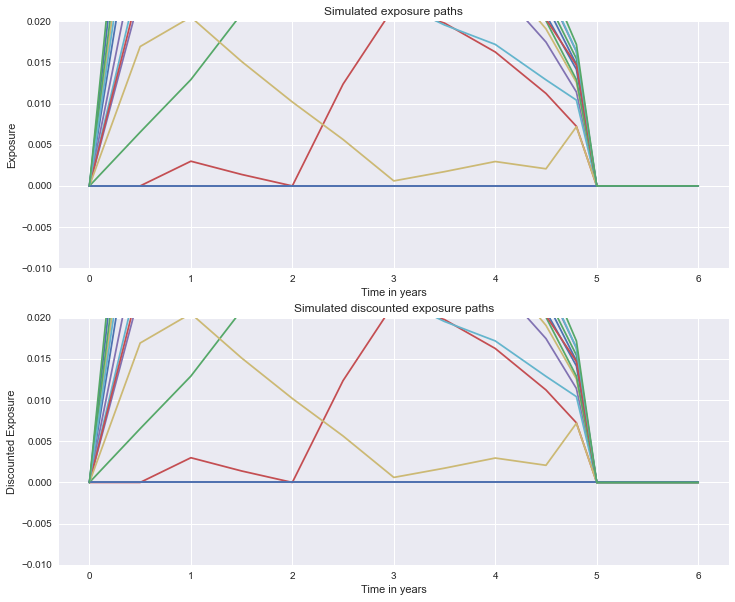

In [67]:
# Calculate the exposure and discounted exposure
E = portfolio_npv.copy()
dE = discounted_npv.copy()
E[E<0] = 0
dE[dE<0] = 0
# Plot the first 20 exposure paths
n = 20
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,10))
for i in range(0,n):
    ax1.plot(time_grid2, E[i,:])
for i in range(0,n):
    ax2.plot(time_grid2, dE[i,:])
ax1.set_xlabel("Time in years")
ax1.set_ylabel("Exposure")
ax1.set_ylim([-.01,0.02])
ax1.set_title("Simulated exposure paths")
ax2.set_xlabel("Time in years")
ax2.set_ylabel("Discounted Exposure")
ax2.set_ylim([-.01,0.02])
ax2.set_title("Simulated discounted exposure paths")

In [68]:
# Calculate the expected exposure
E = portfolio_npv.copy()
E[E<0]=0
EE = np.sum(E, axis=0)/N
EE_max = np.max(EE)
EE_P975 = np.percentile(EE,97.5)
EE_90 = np.quantile(EE,0.90)
EE_80 = np.quantile(EE,0.80)
EE_75 = np.quantile(EE,0.75)
EE_60 = np.quantile(EE,0.60)
EE_mean = np.mean(EE)

In [69]:
EE_max,EE_P975,EE_90,EE_80,EE_75,EE_60,EE_mean

(0.03123157462822278,
 0.0310476920734297,
 0.03036861231695028,
 0.028570254628179144,
 0.02737284086679587,
 0.025228244878667472,
 0.017962548657939552)

In [70]:
# Calculate the discounted expected exposure
dE = discounted_npv.copy()
dE[dE<0] = 0
dEE = np.sum(dE, axis=0)/N
dEE_max = np.max(dEE)
dEE_P975 = np.percentile(dEE,97.5)
dEE_90 = np.quantile(dEE,0.90)
dEE_80 = np.quantile(dEE,0.80)
dEE_75 = np.quantile(dEE,0.75)
dEE_60 = np.quantile(dEE,0.60)
dEE_mean = np.mean(dEE)

In [71]:
dEE_max,dEE_P975,dEE_90,dEE_80,dEE_75,dEE_60,dEE_mean

(0.03123157462822278,
 0.0310476920734297,
 0.03036861231695028,
 0.028570254628179144,
 0.02737284086679587,
 0.025228244878667472,
 0.017962548657939552)

Text(0.5, 1.0, 'Discounted expected exposure')

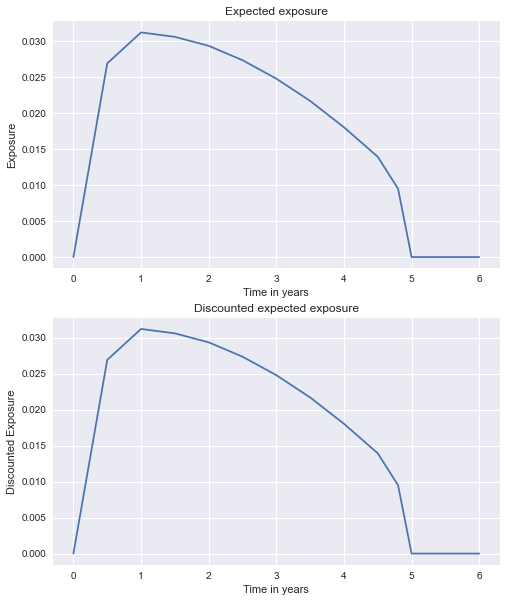

In [72]:
# plot the expected exposure path
n = 20
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10))
ax1.plot(time_grid2, EE)
ax2.plot(time_grid2, dEE)
ax1.set_xlabel("Time in years")
ax1.set_ylabel("Exposure")
ax1.set_title("Expected exposure")
ax2.set_xlabel("Time in years")
ax2.set_ylabel("Discounted Exposure")
ax2.set_title("Discounted expected exposure")

In [73]:
# Calculate the PFE curve (97,5% quantile)
PFE_curve = np.apply_along_axis(lambda x: np.sort(x)[int(0.975*N)],0, E)

In [74]:
PFE_max = np.max(PFE_curve)
PFE_mean = np.mean(PFE_curve) 
PFE_max, PFE_mean

(0.07347324336187395, 0.038378513335350035)

Text(0.5, 1.0, 'PFE (netting set)')

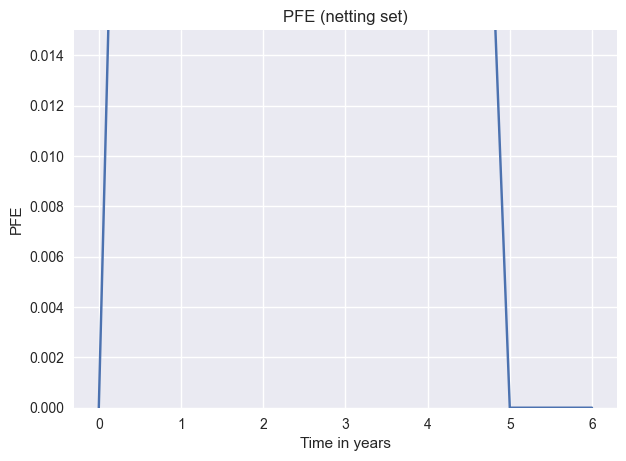

In [75]:
plt.figure(figsize=(7,5), dpi=100)
plt.plot(time_grid2,PFE_curve)
plt.xlabel("Time in years")
plt.ylabel("PFE")
plt.ylim([0,.015])
plt.title("PFE (netting set)")

In [76]:
# calculate the maximum pfe
MPFE = np.max(PFE_curve)
MPFE

0.07347324336187395

In [77]:
# alternative pfe 95% quantile of the maxima of each exposure paths
PFE = np.sort(np.max(E,axis=1))[int(0.95*N)]
PFE

0.07040479143574159

In [78]:
Spot_Curve_OIS_Zero

array([0.01956947, 0.01769612, 0.01672359, 0.01569269, 0.01539805,
       0.01508257, 0.01506552, 0.01501684, 0.01514029, 0.01524292])

In [79]:
depo_maturities = [ ql.Period(6, ql.Months), ql.Period(1, ql.Years),
          ql.Period(18, ql.Months), ql.Period(2, ql.Years),
          ql.Period(30, ql.Months),ql.Period(3, ql.Years),
          ql.Period(42, ql.Months),ql.Period(4, ql.Years),
          ql.Period(54, ql.Months),ql.Period(5, ql.Years) ]
depo_rates = Spot_Curve_OIS_Zero

In [80]:
calc_date = ql.Date(15, ql.May, 2019)
ql.Settings.instance().evaluationDate = calc_date
calendar = ql.UnitedStates()
business_convention = ql.Unadjusted
day_count = ql.Thirty360()
end_of_month = True
settlement_days = 0
face_amount = 100
coupon_frequency = ql.Period(ql.Semiannual)
settlement_days = 0

In [81]:
rate_helpers = [
            ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r/100.0)),
                                 m,
                                 settlement_days,
                                 calendar,
                                 business_convention,
                                 end_of_month,
                                 day_count)
for r, m in zip(depo_rates, depo_maturities) ]

In [82]:
def get_spot_rates( yieldcurve, day_count, calendar = ql.UnitedStates(), months = 121):
    spots = []
    tenors = []
    ref_date = yieldcurve.referenceDate()
    calc_date = ref_date
    for month in range(0, months):
        yrs = month/12.0
        d = calendar.advance(ref_date, ql.Period(month, ql.Months))
        compounding = ql.Compounded
        freq = ql.Semiannual
        zero_rate = yieldcurve.zeroRate(yrs, compounding, freq)
        tenors.append(yrs)
        eq_rate = zero_rate.equivalentRate(day_count,compounding,freq,calc_date,d).rate()
        spots.append(100*eq_rate)

In [83]:
yc = ql.PiecewiseLogCubicDiscount(calc_date, rate_helpers, day_count)

In [84]:
calendar = ql.TARGET()

# set evaluation date
todaysDate = ql.Date(15, ql.May, 2019)
todaysDate = calendar.adjust(todaysDate)
ql.Settings.instance().evaluationDate = todaysDate

risk_free_rate = ql.YieldTermStructureHandle(yc)

In [85]:
# CDS parameters
recovery_rate = 0.4
quoted_spreads = [0.0150, 0.0300, 0.03200, 0.0350,0.0400,0.0450,0.0500,0.0550,0.060]
tenors = [ ql.Period(6, ql.Months), ql.Period(1, ql.Years),
          ql.Period(18, ql.Months), ql.Period(2, ql.Years),
          ql.Period(30, ql.Months),ql.Period(3, ql.Years),
          ql.Period(42, ql.Months),ql.Period(4, ql.Years),
          ql.Period(54, ql.Months),ql.Period(5, ql.Years) ]

maturities = [calendar.adjust(todaysDate + x, ql.Following) for x in tenors]

In [86]:
instruments = [
    ql.SpreadCdsHelper(
        ql.QuoteHandle(ql.SimpleQuote(s)),
        tenor,
        0,
        calendar,
        ql.Quarterly,
        ql.Following,
        ql.DateGeneration.TwentiethIMM,
        ql.Actual365Fixed(),
        recovery_rate,
        risk_free_rate
    )
    for s, tenor in zip(quoted_spreads, tenors)
]

In [87]:
hazard_curve = ql.PiecewiseFlatHazardRate(todaysDate, instruments, ql.Actual365Fixed())

In [88]:
hazard_rates = []
for x in hazard_curve.nodes():
    hazard_rates.append( x[1] )

In [89]:
hazard_rates = np.array(hazard_rates)

pd.DataFrame(hazard_rates)

,0
0,0.024884
1,0.024884
2,0.080603
3,0.060803
4,0.075604
5,0.105316
6,0.124857
7,0.145258
8,0.168078
9,0.192218


In [90]:
pd_dates =  [todaysDate + ql.Period(i*6, ql.Months) for i in range(10)]
pd_curve = ql.HazardRateCurve(pd_dates,hazard_rates,ql.Actual365Fixed())
pd_curve.enableExtrapolation()
pd_curve.nodes

<bound method HazardRateCurve.nodes of <QuantLib.QuantLib.HazardRateCurve; proxy of <Swig Object of type 'ext::shared_ptr< InterpolatedHazardRateCurve< BackwardFlat > > *' at 0x00000184029E7990> >>

Text(0.5, 1.0, 'Harzard rate')

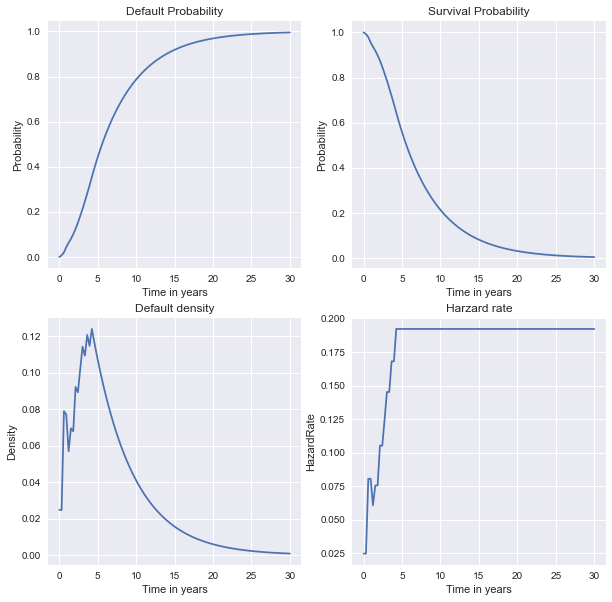

In [91]:
# Plot curve
# Calculate default probs on grid *times*
times = np.linspace(0,30,100)
dp = np.vectorize(pd_curve.defaultProbability)(times)
sp = np.vectorize(pd_curve.survivalProbability)(times)
dd = np.vectorize(pd_curve.defaultDensity)(times)
hr = np.vectorize(pd_curve.hazardRate)(times)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.plot(times, dp)
ax2.plot(times, sp)
ax3.plot(times, dd)
ax4.plot(times, hr)
ax1.set_xlabel("Time in years")
ax2.set_xlabel("Time in years")
ax3.set_xlabel("Time in years")
ax4.set_xlabel("Time in years")
ax1.set_ylabel("Probability")
ax2.set_ylabel("Probability")
ax3.set_ylabel("Density")
ax4.set_ylabel("HazardRate")
ax1.set_title("Default Probability")
ax2.set_title("Survival Probability")
ax3.set_title("Default density")
ax4.set_title("Harzard rate")

In [92]:
# Calculation of the default probs
defaultProb_vec = np.vectorize(pd_curve.defaultProbability)
dPD = defaultProb_vec(time_grid2[:-1], time_grid2[1:])

In [93]:
# Calculation of the CVA
recovery = 0.4
CVA = (1-recovery) * np.sum(dEE[1:] * dPD)
CVA

0.0056251739723305405

In [94]:
CVA_1 = (1-recovery) * np.sum(dPD) * dEE_max
CVA_1

0.01011764631275302

In [95]:
CVA_2 = (1-recovery) * np.sum(dPD) * dEE_P975
CVA_2

0.010058076512810864

In [96]:
CVA_3 = (1-recovery) * np.sum(dPD) * dEE_90
CVA_3

0.009838084761642467

In [97]:
CVA_4 = (1-recovery) * np.sum(dPD) * dEE_80
CVA_4

0.009255496555463323

In [98]:
CVA_5 = (1-recovery) * np.sum(dPD) * dEE_75
CVA_5

0.00886758755401479

In [99]:
CVA_6 = (1-recovery) * np.sum(dPD) * dEE_60
CVA_6

0.008172833480615484

In [100]:
CVA_7 = (1-recovery) * np.sum(dPD) * dEE_mean
CVA_7

0.0058190698471033385

In [101]:
CVA_porcent_Notional = CVA*100/1
CVA_porcent_Notional

0.562517397233054